# Reward Function Comparison (Per-Reward Tuned)

This notebook trains and evaluates PPO and DQN using per-reward tuned hyperparameters.
It compares shaped-reward performance and default-reward success rates.
Outputs are saved under `results/reward_comparison_tuned`.

In [1]:
import sys

sys.path.append('..')

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio

from reinforcement_learning_taxi.agents.dqn_agent import DQNAgent
from reinforcement_learning_taxi.agents.ppo_agent import PPOAgent
from reinforcement_learning_taxi.environments import make_taxi_env
from reinforcement_learning_taxi.environments.reward_wrappers import REWARD_FUNCTIONS
from reinforcement_learning_taxi.evaluation.metrics import evaluate_agent
from reinforcement_learning_taxi.training.dqn_trainer import DQNTrainer
from reinforcement_learning_taxi.training.ppo_trainer import PPOTrainer
from reinforcement_learning_taxi.utils.config_utils import load_config
from reinforcement_learning_taxi.utils.path_utils import get_repo_root

In [2]:
ROOT_DIR = get_repo_root()
RESULTS_DIR = ROOT_DIR / 'results/reward_comparison_tuned'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

RENDER_DIR = ROOT_DIR / 'results/renders'
RENDER_DIR.mkdir(parents=True, exist_ok=True)

PPO_CONFIG_DIR = ROOT_DIR / 'results/hyperparameter_tuning/ppo_per_reward'
DQN_CONFIG_DIR = ROOT_DIR / 'results/hyperparameter_tuning/dqn_per_reward'

PPO_TOTAL_TIMESTEPS = 200000
DQN_TOTAL_TIMESTEPS = 250000
N_EVAL_EPISODES = 200
SEED = 42

reward_functions = list(REWARD_FUNCTIONS.keys())
print(f'Reward functions: {reward_functions}')
print(f'PPO timesteps: {PPO_TOTAL_TIMESTEPS:,}')
print(f'DQN timesteps: {DQN_TOTAL_TIMESTEPS:,}')
print(f'Evaluation episodes: {N_EVAL_EPISODES}')

Reward functions: ['default', 'distance_based', 'modified_penalty', 'enhanced']
PPO timesteps: 200,000
DQN timesteps: 250,000
Evaluation episodes: 200


In [3]:
def load_best_config(config_dir: Path, reward_name: str, algo: str) -> dict:
    config_path = config_dir / f'{algo}_{reward_name}_best.yaml'
    if not config_path.exists():
        raise FileNotFoundError(f'Missing tuned config: {config_path}')
    return load_config(config_path)



def record_rollouts(agent, reward_name, algo_label, use_action_masking, n_episodes=10, max_steps=200, fps=10):
    video_path = RENDER_DIR / f"{algo_label}_{reward_name}_10runs.mp4"
    pause_frames = fps
    seeds = [999 + i for i in range(n_episodes)]
    episode_stats = []

    env_render = make_taxi_env(
        render_mode='rgb_array',
        use_feature_wrapper=True,
        reward_wrapper_name=reward_name,
        use_action_masking=use_action_masking,
    )

    with imageio.get_writer(video_path, fps=fps) as writer:
        for i, seed in enumerate(seeds, start=1):
            state, _ = env_render.reset(seed=seed)
            frame = env_render.render()
            writer.append_data(frame)
            done = False
            steps = 0
            ep_reward = 0

            while not done and steps < max_steps:
                if use_action_masking:
                    action, _ = agent.predict(
                        state,
                        deterministic=True,
                        action_masks=env_render.action_masks(),
                    )
                else:
                    action, _ = agent.predict(state, deterministic=True)

                if isinstance(action, np.ndarray):
                    action = int(action.item())

                state, reward, terminated, truncated, _ = env_render.step(action)
                frame = env_render.render()
                writer.append_data(frame)
                done = terminated or truncated
                ep_reward += reward
                steps += 1

            success = ep_reward > 0
            episode_stats.append((steps, ep_reward, success))
            print(f"{algo_label.upper()} {reward_name} episode {i}: steps={steps}, reward={ep_reward}, success={success}")

            if i != len(seeds):
                for _ in range(pause_frames):
                    writer.append_data(frame)

    env_render.close()

    mean_reward = sum(r for _s, r, _su in episode_stats) / len(episode_stats)
    mean_steps = sum(s for s, _r, _su in episode_stats) / len(episode_stats)
    success_rate = sum(1 for _s, _r, su in episode_stats if su) / len(episode_stats)

    print(f"Video saved to {video_path}")
    print(f"Summary: mean_reward={mean_reward:.2f}, mean_steps={mean_steps:.2f}, success_rate={success_rate:.2%}")


In [4]:
ppo_results = {}

for reward_name in reward_functions:
    print(f"\n{'=' * 70}")
    print(f"PPO comparison run for reward: {reward_name}")
    print(f"{'=' * 70}")

    cfg = load_best_config(PPO_CONFIG_DIR, reward_name, 'ppo')
    agent_cfg = cfg['agent']

    env = make_taxi_env(
        use_feature_wrapper=True,
        reward_wrapper_name=reward_name,
        use_action_masking=True,
    )

    agent = PPOAgent(
        env=env,
        policy=agent_cfg['policy'],
        learning_rate=agent_cfg['learning_rate'],
        n_steps=agent_cfg['n_steps'],
        batch_size=agent_cfg['batch_size'],
        n_epochs=agent_cfg['n_epochs'],
        gamma=agent_cfg['gamma'],
        gae_lambda=agent_cfg['gae_lambda'],
        clip_range=agent_cfg['clip_range'],
        clip_range_vf=agent_cfg['clip_range_vf'],
        ent_coef=agent_cfg['ent_coef'],
        vf_coef=agent_cfg['vf_coef'],
        max_grad_norm=agent_cfg['max_grad_norm'],
        policy_kwargs=agent_cfg.get('policy_kwargs') or {},
        verbose=0,
        seed=agent_cfg.get('seed', SEED),
        use_action_masking=True,
    )

    trainer = PPOTrainer(
        env=env,
        agent=agent,
        log_dir=RESULTS_DIR / f'logs/ppo_{reward_name}',
        eval_freq=10000,
    )
    stats = trainer.train(total_timesteps=PPO_TOTAL_TIMESTEPS)

    eval_shaped = evaluate_agent(agent, env, n_episodes=N_EVAL_EPISODES, deterministic=True)
    eval_env_default = make_taxi_env(
        use_feature_wrapper=True,
        reward_wrapper_name=None,
        use_action_masking=True,
    )
    eval_default = evaluate_agent(
        agent,
        eval_env_default,
        n_episodes=N_EVAL_EPISODES,
        deterministic=True,
    )
    eval_env_default.close()

    record_rollouts(agent, reward_name, "ppo", use_action_masking=True)

    env.close()

    ppo_results[reward_name] = {
        'stats': stats,
        'eval_shaped': eval_shaped,
        'eval_default': eval_default,
    }

    print(f"  Mean reward (shaped): {eval_shaped['mean_reward']:.2f}")
    print(f"  Success rate (default): {eval_default['success_rate']:.2%}")


PPO comparison run for reward: default
Eval num_timesteps=10000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=-183.06 +/- 57.45
Episode length: 184.74 +/- 51.75
New best mean reward!
Eval num_timesteps=30000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
Eval num_timesteps=50000, episode_reward=-170.76 +/- 72.48
Episode length: 173.70 +/- 65.19
New best mean reward!
Eval num_timesteps=60000, episode_reward=-126.93 +/- 99.59
Episode length: 134.28 +/- 89.58
New best mean reward!
Eval num_timesteps=70000, episode_reward=-160.10 +/- 82.39
Episode length: 164.09 +/- 74.15
Eval num_timesteps=80000, episode_reward=-117.09 +/- 101.56
Episode length: 125.49 +/- 91.27
New best mean reward!
Eval num_timesteps=90000, episode_reward=-42.16 +/- 88.72
Episode length: 58.12 +/- 79.75
New best mean reward!
Eval nu

/Users/azernaczuk/Documents/0sobiste/github/reinforcement_learning_taxi/.venv/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


PPO default episode 1: steps=10, reward=11, success=True
PPO default episode 2: steps=15, reward=6, success=True
PPO default episode 3: steps=17, reward=4, success=True
PPO default episode 4: steps=13, reward=8, success=True
PPO default episode 5: steps=17, reward=4, success=True
PPO default episode 6: steps=10, reward=11, success=True
PPO default episode 7: steps=16, reward=5, success=True
PPO default episode 8: steps=9, reward=12, success=True
PPO default episode 9: steps=15, reward=6, success=True
PPO default episode 10: steps=17, reward=4, success=True
Video saved to /Users/azernaczuk/Documents/0sobiste/github/reinforcement_learning_taxi/results/renders/ppo_default_10runs.mp4
Summary: mean_reward=7.10, mean_steps=13.90, success_rate=100.00%
  Mean reward (shaped): 8.09
  Success rate (default): 100.00%

PPO comparison run for reward: distance_based
Eval num_timesteps=10000, episode_reward=-199.81 +/- 0.35
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


PPO distance_based episode 1: steps=10, reward=11.799999999999999, success=True
PPO distance_based episode 2: steps=15, reward=6.899999999999999, success=True
PPO distance_based episode 3: steps=17, reward=5.099999999999998, success=True
PPO distance_based episode 4: steps=13, reward=9.099999999999998, success=True
PPO distance_based episode 5: steps=17, reward=5.099999999999998, success=True
PPO distance_based episode 6: steps=10, reward=11.399999999999999, success=True
PPO distance_based episode 7: steps=16, reward=5.599999999999998, success=True
PPO distance_based episode 8: steps=9, reward=12.7, success=True
PPO distance_based episode 9: steps=15, reward=7.299999999999997, success=True
PPO distance_based episode 10: steps=17, reward=5.099999999999996, success=True
Video saved to /Users/azernaczuk/Documents/0sobiste/github/reinforcement_learning_taxi/results/renders/ppo_distance_based_10runs.mp4
Summary: mean_reward=8.01, mean_steps=13.90, success_rate=100.00%
  Mean reward (shaped)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


PPO modified_penalty episode 1: steps=10, reward=15.5, success=True
PPO modified_penalty episode 2: steps=15, reward=13.0, success=True
PPO modified_penalty episode 3: steps=17, reward=12.0, success=True
PPO modified_penalty episode 4: steps=13, reward=14.0, success=True
PPO modified_penalty episode 5: steps=17, reward=12.0, success=True
PPO modified_penalty episode 6: steps=10, reward=15.5, success=True
PPO modified_penalty episode 7: steps=18, reward=11.5, success=True
PPO modified_penalty episode 8: steps=9, reward=16.0, success=True
PPO modified_penalty episode 9: steps=15, reward=13.0, success=True
PPO modified_penalty episode 10: steps=17, reward=12.0, success=True
Video saved to /Users/azernaczuk/Documents/0sobiste/github/reinforcement_learning_taxi/results/renders/ppo_modified_penalty_10runs.mp4
Summary: mean_reward=13.45, mean_steps=14.10, success_rate=100.00%
  Mean reward (shaped): 14.02
  Success rate (default): 100.00%

PPO comparison run for reward: enhanced
Eval num_time

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


PPO enhanced episode 1: steps=10, reward=19.6, success=True
PPO enhanced episode 2: steps=15, reward=14.799999999999999, success=True
PPO enhanced episode 3: steps=17, reward=13.199999999999998, success=True
PPO enhanced episode 4: steps=13, reward=17.200000000000003, success=True
PPO enhanced episode 5: steps=17, reward=13.199999999999998, success=True
PPO enhanced episode 6: steps=10, reward=18.8, success=True
PPO enhanced episode 7: steps=16, reward=13.199999999999998, success=True
PPO enhanced episode 8: steps=9, reward=20.4, success=True
PPO enhanced episode 9: steps=15, reward=15.6, success=True
PPO enhanced episode 10: steps=17, reward=13.199999999999998, success=True
Video saved to /Users/azernaczuk/Documents/0sobiste/github/reinforcement_learning_taxi/results/renders/ppo_enhanced_10runs.mp4
Summary: mean_reward=15.92, mean_steps=13.90, success_rate=100.00%
  Mean reward (shaped): -7.84
  Success rate (default): 91.00%


In [5]:
dqn_results = {}

for reward_name in reward_functions:
    print(f"\n{'=' * 70}")
    print(f"DQN comparison run for reward: {reward_name}")
    print(f"{'=' * 70}")

    cfg = load_best_config(DQN_CONFIG_DIR, reward_name, 'dqn')
    agent_cfg = cfg['agent']

    env = make_taxi_env(
        use_feature_wrapper=True,
        reward_wrapper_name=reward_name,
        use_action_masking=False,
    )

    agent = DQNAgent(
        env=env,
        policy=agent_cfg['policy'],
        learning_rate=agent_cfg['learning_rate'],
        buffer_size=agent_cfg['buffer_size'],
        learning_starts=agent_cfg['learning_starts'],
        batch_size=agent_cfg['batch_size'],
        gamma=agent_cfg['gamma'],
        train_freq=agent_cfg['train_freq'],
        gradient_steps=agent_cfg['gradient_steps'],
        target_update_interval=agent_cfg['target_update_interval'],
        exploration_fraction=agent_cfg['exploration_fraction'],
        exploration_initial_eps=agent_cfg['exploration_initial_eps'],
        exploration_final_eps=agent_cfg['exploration_final_eps'],
        policy_kwargs=agent_cfg.get('policy_kwargs') or {},
        verbose=0,
        seed=agent_cfg.get('seed', SEED),
    )

    trainer = DQNTrainer(
        env=env,
        agent=agent,
        log_dir=RESULTS_DIR / f'logs/dqn_{reward_name}',
        eval_freq=10000,
        eval_episodes=N_EVAL_EPISODES,
    )
    stats = trainer.train(total_timesteps=DQN_TOTAL_TIMESTEPS)

    eval_shaped = evaluate_agent(agent, env, n_episodes=N_EVAL_EPISODES, deterministic=True)
    eval_env_default = make_taxi_env(
        use_feature_wrapper=True,
        reward_wrapper_name=None,
        use_action_masking=False,
    )
    eval_default = evaluate_agent(
        agent,
        eval_env_default,
        n_episodes=N_EVAL_EPISODES,
        deterministic=True,
    )
    eval_env_default.close()

    record_rollouts(agent, reward_name, "dqn", use_action_masking=False)

    env.close()

    dqn_results[reward_name] = {
        'stats': stats,
        'eval_shaped': eval_shaped,
        'eval_default': eval_default,
    }

    print(f"  Mean reward (shaped): {eval_shaped['mean_reward']:.2f}")
    print(f"  Success rate (default): {eval_default['success_rate']:.2%}")


DQN comparison run for reward: default
Eval num_timesteps=10000, episode_reward=-1991.00 +/- 126.96
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=30000, episode_reward=-188.46 +/- 47.86
Episode length: 189.61 +/- 43.07
New best mean reward!
Eval num_timesteps=40000, episode_reward=-144.35 +/- 92.68
Episode length: 149.91 +/- 83.42
New best mean reward!
Eval num_timesteps=50000, episode_reward=-18.19 +/- 68.76
Episode length: 36.56 +/- 61.82
New best mean reward!
Eval num_timesteps=60000, episode_reward=-92.67 +/- 104.18
Episode length: 103.48 +/- 93.69
Eval num_timesteps=70000, episode_reward=-60.56 +/- 97.88
Episode length: 74.64 +/- 88.01
Eval num_timesteps=80000, episode_reward=7.66 +/- 2.43
Episode length: 13.35 +/- 2.43
New best mean reward!
Eval num_timesteps=90000, episode_reward=7.78 +/- 2.73
Episode length: 13.22 +/- 2.73
New best mean rew

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


DQN default episode 1: steps=10, reward=11, success=True
DQN default episode 2: steps=15, reward=6, success=True
DQN default episode 3: steps=17, reward=4, success=True
DQN default episode 4: steps=13, reward=8, success=True
DQN default episode 5: steps=17, reward=4, success=True
DQN default episode 6: steps=10, reward=11, success=True
DQN default episode 7: steps=16, reward=5, success=True
DQN default episode 8: steps=9, reward=12, success=True
DQN default episode 9: steps=15, reward=6, success=True
DQN default episode 10: steps=17, reward=4, success=True
Video saved to /Users/azernaczuk/Documents/0sobiste/github/reinforcement_learning_taxi/results/renders/dqn_default_10runs.mp4
Summary: mean_reward=7.10, mean_steps=13.90, success_rate=100.00%
  Mean reward (shaped): 7.83
  Success rate (default): 100.00%

DQN comparison run for reward: distance_based
Eval num_timesteps=10000, episode_reward=-1991.00 +/- 126.96
Episode length: 200.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


DQN distance_based episode 1: steps=10, reward=11.799999999999999, success=True
DQN distance_based episode 2: steps=15, reward=6.899999999999999, success=True
DQN distance_based episode 3: steps=17, reward=5.099999999999998, success=True
DQN distance_based episode 4: steps=13, reward=9.099999999999998, success=True
DQN distance_based episode 5: steps=17, reward=5.099999999999998, success=True
DQN distance_based episode 6: steps=10, reward=11.399999999999999, success=True
DQN distance_based episode 7: steps=16, reward=5.599999999999998, success=True
DQN distance_based episode 8: steps=9, reward=12.7, success=True
DQN distance_based episode 9: steps=15, reward=7.299999999999997, success=True
DQN distance_based episode 10: steps=17, reward=5.099999999999996, success=True
Video saved to /Users/azernaczuk/Documents/0sobiste/github/reinforcement_learning_taxi/results/renders/dqn_distance_based_10runs.mp4
Summary: mean_reward=8.01, mean_steps=13.90, success_rate=100.00%
  Mean reward (shaped)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


DQN modified_penalty episode 1: steps=10, reward=15.5, success=True
DQN modified_penalty episode 2: steps=15, reward=13.0, success=True
DQN modified_penalty episode 3: steps=17, reward=12.0, success=True
DQN modified_penalty episode 4: steps=13, reward=14.0, success=True
DQN modified_penalty episode 5: steps=17, reward=12.0, success=True
DQN modified_penalty episode 6: steps=10, reward=15.5, success=True
DQN modified_penalty episode 7: steps=16, reward=12.5, success=True
DQN modified_penalty episode 8: steps=9, reward=16.0, success=True
DQN modified_penalty episode 9: steps=15, reward=13.0, success=True
DQN modified_penalty episode 10: steps=17, reward=12.0, success=True
Video saved to /Users/azernaczuk/Documents/0sobiste/github/reinforcement_learning_taxi/results/renders/dqn_modified_penalty_10runs.mp4
Summary: mean_reward=13.55, mean_steps=13.90, success_rate=100.00%
  Mean reward (shaped): 13.85
  Success rate (default): 100.00%

DQN comparison run for reward: enhanced
Eval num_time

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


DQN enhanced episode 1: steps=10, reward=19.6, success=True
DQN enhanced episode 2: steps=15, reward=14.799999999999999, success=True
DQN enhanced episode 3: steps=17, reward=13.199999999999998, success=True
DQN enhanced episode 4: steps=13, reward=17.200000000000003, success=True
DQN enhanced episode 5: steps=17, reward=13.199999999999998, success=True
DQN enhanced episode 6: steps=10, reward=18.8, success=True
DQN enhanced episode 7: steps=16, reward=13.199999999999998, success=True
DQN enhanced episode 8: steps=9, reward=20.4, success=True
DQN enhanced episode 9: steps=15, reward=15.6, success=True
DQN enhanced episode 10: steps=17, reward=13.199999999999998, success=True
Video saved to /Users/azernaczuk/Documents/0sobiste/github/reinforcement_learning_taxi/results/renders/dqn_enhanced_10runs.mp4
Summary: mean_reward=15.92, mean_steps=13.90, success_rate=100.00%
  Mean reward (shaped): 16.78
  Success rate (default): 100.00%


In [6]:
def build_comparison_df(results, algo_label):
    rows = []
    for reward_name, data in results.items():
        eval_shaped = data['eval_shaped']
        eval_default = data['eval_default']
        stats = data['stats']
        rows.append({
            'Algorithm': algo_label,
            'Reward Function': reward_name,
            'Mean Reward (shaped)': f"{eval_shaped['mean_reward']:.2f}",
            'Std Reward (shaped)': f"{eval_shaped['std_reward']:.2f}",
            'Success Rate (default)': f"{eval_default['success_rate']:.1%}",
            'Mean Length (default)': f"{eval_default['mean_length']:.1f}",
            'Training Time (s)': f"{stats['training_time']:.1f}",
        })
    return pd.DataFrame(rows)

ppo_df = build_comparison_df(ppo_results, 'PPO')
dqn_df = build_comparison_df(dqn_results, 'DQN')

ppo_csv = RESULTS_DIR / 'ppo_reward_comparison_tuned.csv'
dqn_csv = RESULTS_DIR / 'dqn_reward_comparison_tuned.csv'
ppo_df.to_csv(ppo_csv, index=False)
dqn_df.to_csv(dqn_csv, index=False)

print(f'PPO comparison saved to {ppo_csv}')
print(f'DQN comparison saved to {dqn_csv}')

PPO comparison saved to /Users/azernaczuk/Documents/0sobiste/github/reinforcement_learning_taxi/results/reward_comparison_tuned/ppo_reward_comparison_tuned.csv
DQN comparison saved to /Users/azernaczuk/Documents/0sobiste/github/reinforcement_learning_taxi/results/reward_comparison_tuned/dqn_reward_comparison_tuned.csv


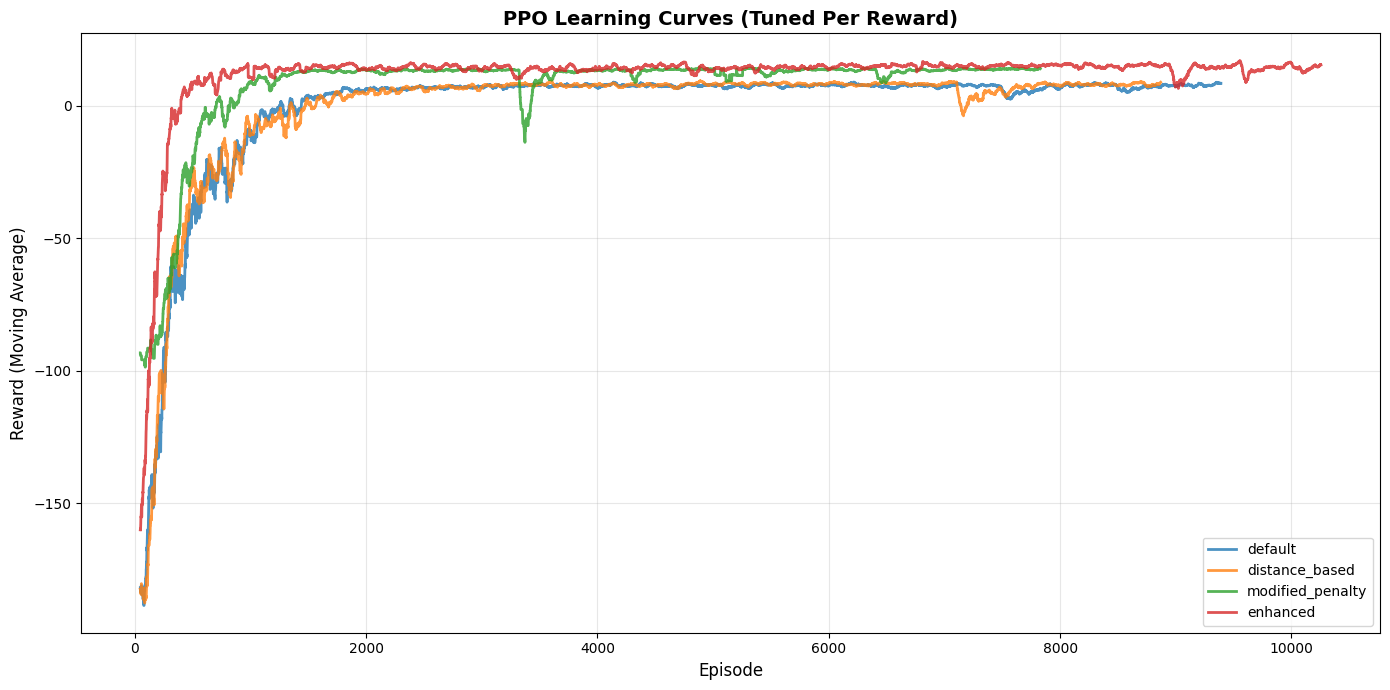

Learning curves saved to /Users/azernaczuk/Documents/0sobiste/github/reinforcement_learning_taxi/results/reward_comparison_tuned/ppo_learning_curves_tuned.png


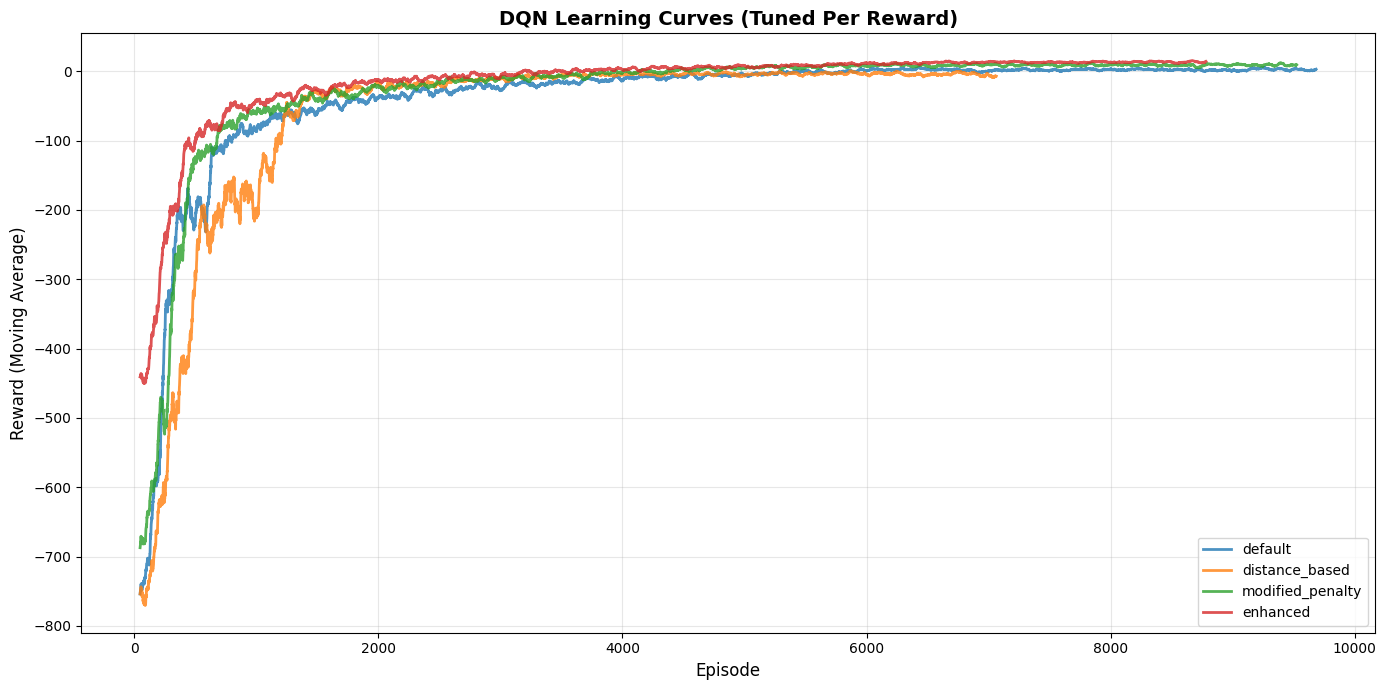

Learning curves saved to /Users/azernaczuk/Documents/0sobiste/github/reinforcement_learning_taxi/results/reward_comparison_tuned/dqn_learning_curves_tuned.png


In [7]:
def plot_learning_curves(results, title, save_path):
    fig, ax = plt.subplots(figsize=(14, 7))
    for reward_name, data in results.items():
        rewards = data['stats']['episode_rewards']
        if rewards:
            window = max(1, min(50, len(rewards) // 10))
            moving_avg = np.convolve(rewards, np.ones(window) / window, mode='valid')
            episodes = range(window - 1, len(rewards))
            ax.plot(episodes, moving_avg, linewidth=2, label=reward_name, alpha=0.8)

    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Reward (Moving Average)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'Learning curves saved to {save_path}')

plot_learning_curves(
    ppo_results,
    'PPO Learning Curves (Tuned Per Reward)',
    RESULTS_DIR / 'ppo_learning_curves_tuned.png',
)
plot_learning_curves(
    dqn_results,
    'DQN Learning Curves (Tuned Per Reward)',
    RESULTS_DIR / 'dqn_learning_curves_tuned.png',
)

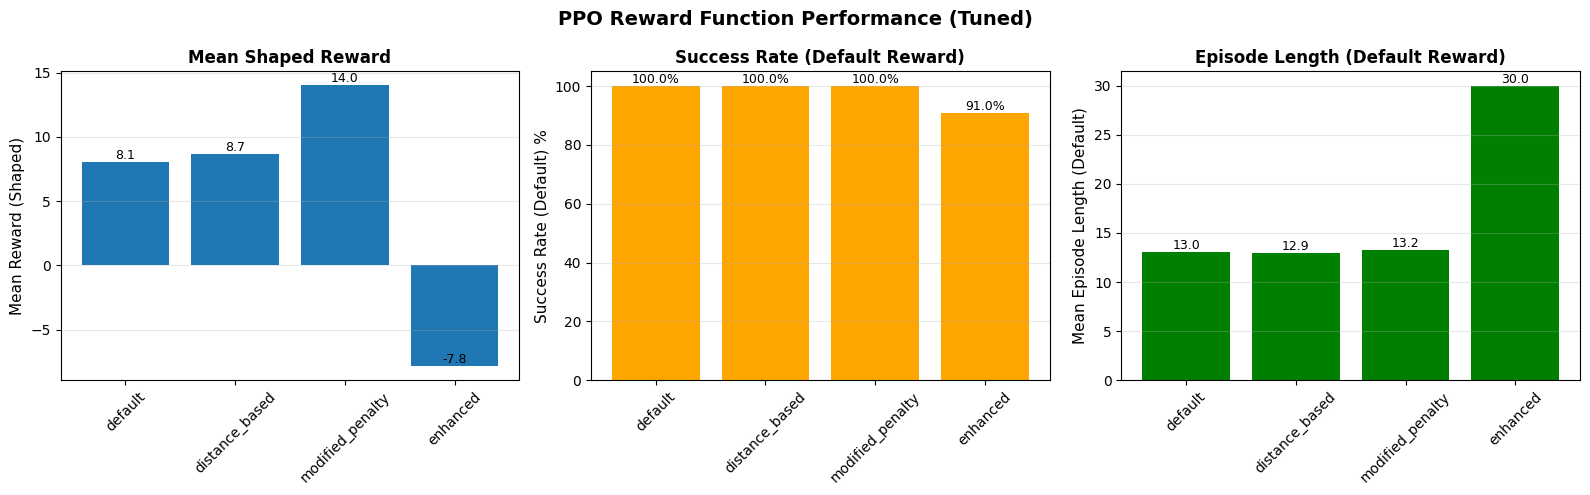

Performance comparison saved to /Users/azernaczuk/Documents/0sobiste/github/reinforcement_learning_taxi/results/reward_comparison_tuned/ppo_performance_comparison_tuned.png


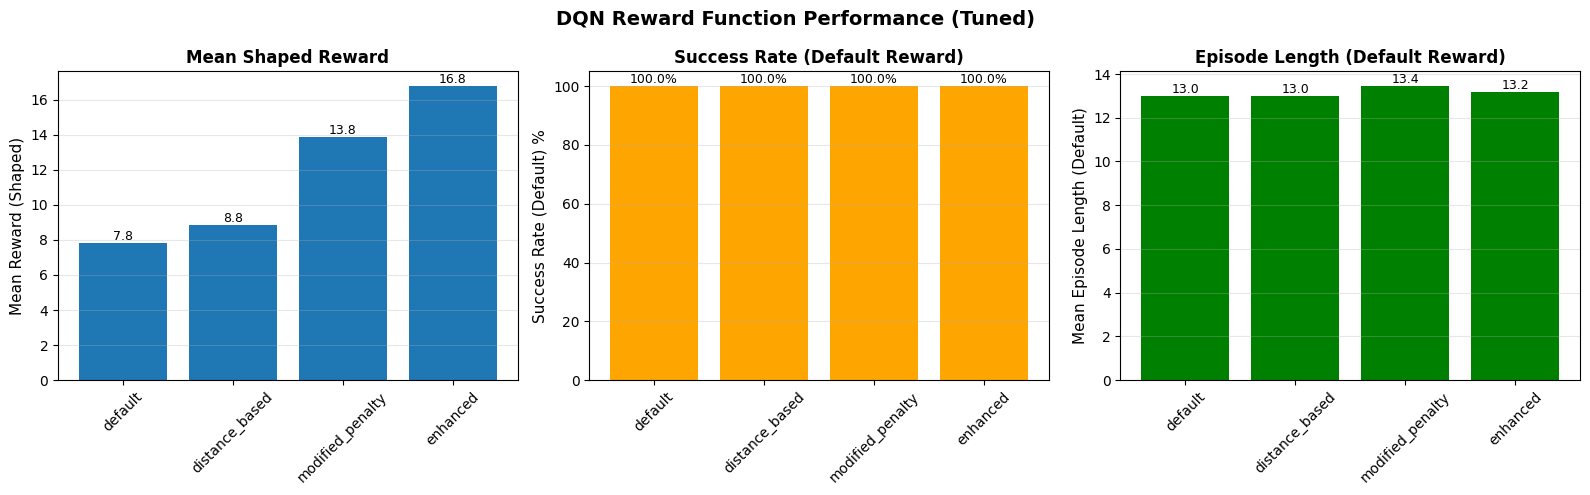

Performance comparison saved to /Users/azernaczuk/Documents/0sobiste/github/reinforcement_learning_taxi/results/reward_comparison_tuned/dqn_performance_comparison_tuned.png


In [8]:
def plot_performance_bars(results, title, save_path):
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    names = list(results.keys())
    mean_rewards = [results[name]['eval_shaped']['mean_reward'] for name in names]
    success_rates = [results[name]['eval_default']['success_rate'] * 100 for name in names]
    episode_lengths = [results[name]['eval_default']['mean_length'] for name in names]

    bars1 = axes[0].bar(names, mean_rewards)
    axes[0].set_ylabel('Mean Reward (Shaped)', fontsize=11)
    axes[0].set_title('Mean Shaped Reward', fontsize=12, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars1, mean_rewards):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height, f'{val:.1f}', ha='center', va='bottom', fontsize=9)

    bars2 = axes[1].bar(names, success_rates, color='orange')
    axes[1].set_ylabel('Success Rate (Default) %', fontsize=11)
    axes[1].set_title('Success Rate (Default Reward)', fontsize=12, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars2, success_rates):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height, f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

    bars3 = axes[2].bar(names, episode_lengths, color='green')
    axes[2].set_ylabel('Mean Episode Length (Default)', fontsize=11)
    axes[2].set_title('Episode Length (Default Reward)', fontsize=12, fontweight='bold')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(True, alpha=0.3, axis='y')
    for bar, val in zip(bars3, episode_lengths):
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height, f'{val:.1f}', ha='center', va='bottom', fontsize=9)

    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'Performance comparison saved to {save_path}')

plot_performance_bars(
    ppo_results,
    'PPO Reward Function Performance (Tuned)',
    RESULTS_DIR / 'ppo_performance_comparison_tuned.png',
)
plot_performance_bars(
    dqn_results,
    'DQN Reward Function Performance (Tuned)',
    RESULTS_DIR / 'dqn_performance_comparison_tuned.png',
)